# Using Static Mapping

In [1]:
import transportation_tutorials as tt
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point

## Questions

1. Generate a population density map of Miami-Dade County, at the MAZ resolution level for SERPM 8.

## Data

To answer the question, use the following files:

In [2]:
maz = gpd.read_file(tt.data('SERPM8-MAZSHAPE'))
maz.head()

,OBJECTID,MAZ,SHAPE_LENG,SHAPE_AREA,ACRES,POINT_X,POINT_Y,geometry
0,1,5347,8589.393674,3.111034e+06,71,953130,724165,"POLYGON ((953970.4660769962 723936.0810402408,..."
1,2,5348,11974.067469,7.628753e+06,175,907018,634551,"POLYGON ((908505.2801046632 635081.7738410756,..."
2,3,5349,9446.131753,4.007041e+06,92,923725,707062,"POLYGON ((922736.6374686621 708387.6918614879,..."
3,4,5350,21773.153739,2.487397e+07,571,908988,713484,"POLYGON ((908334.2374677472 715692.2628822401,..."
4,5,5351,17882.701416,1.963139e+07,451,909221,717493,"POLYGON ((911883.0187559947 719309.3261861578,..."


In [3]:
maz_data = pd.read_csv(tt.data('SERPM8-MAZDATA', '*.csv'))
maz_data.head()

,mgra,TAZ,HH,POP,emp_self,emp_ag,emp_const_non_bldg_prod,emp_const_non_bldg_office,emp_utilities_prod,emp_utilities_office,...,EmpDenBin,DuDenBin,POINT_X,POINT_Y,ACRES,HotelRoomTotal,mall_flag,beachAcres,geoSRate,geoSRateNm
0,1,2901,43,169,0,0,0,0,0,0,...,1,1,841743,586817,510,0,0,0,1,1
1,2,2902,9,21,0,1,1006,0,8,0,...,1,1,855391,585688,5678,0,0,0,1,1
2,3,2903,403,1389,0,0,6,0,0,0,...,1,1,858417,549492,85,0,0,0,1,1
3,4,2903,477,1659,0,0,3,0,0,0,...,1,1,858468,552269,103,0,0,0,1,1
4,5,2903,374,1389,0,0,11,0,0,0,...,1,1,859899,552161,72,0,0,0,1,1


In [4]:
fl_county = gpd.read_file(tt.data('FL-COUNTY-SHAPE'))
fl_county.head()

,OBJECTID,DEPCODE,COUNTY,COUNTYNAME,DATESTAMP,ShapeSTAre,ShapeSTLen,geometry
0,1,21,041,GILCHRIST,2000-05-16T00:00:00.000Z,9.908353e+09,4.873000e+05,POLYGON ((-82.65813600527831 29.83028106592836...
1,2,54,107,PUTNAM,2000-05-16T00:00:00.000Z,2.305869e+10,7.629677e+05,POLYGON ((-81.58084263191225 29.83955869988373...
2,3,62,123,TAYLOR,2000-05-16T00:00:00.000Z,2.891747e+10,8.772527e+05,(POLYGON ((-83.73036687278116 30.3035764144186...
3,4,46,091,OKALOOSA,2000-05-16T00:00:00.000Z,2.562159e+10,1.087058e+06,(POLYGON ((-86.39159408384468 30.6497039172779...
4,5,7,013,CALHOUN,2000-05-16T00:00:00.000Z,1.604809e+10,6.313440e+05,POLYGON ((-84.93265667941331 30.60636534524649...


## Solution

We can begin by extracting just Miami-Dade county from the counties shapefile.
As noted, the name is recorded in this file as just "DADE", so we can 
use that to get the correct county.

In [5]:
md_county = fl_county.query("COUNTYNAME == 'DADE'")

The county shapefile uses a different crs, so we'll need to make them aligned before 
doing a join.

In [7]:
md_county = md_county.to_crs({'init': 'epsg:2236', 'no_defs': True})

In [8]:
md_polygon = md_county.iloc[0].geometry

Next, we can select the MAZ centroids that are within the Miami-Dade polygon. 

In [9]:
md_maz = maz[maz.centroid.within(md_polygon)]

Then we merge `maz_data` dataframe with spatially joined `md_maz` 
to pull in the required population information. 

In [10]:
md_maz_info = md_maz.merge(maz_data.astype(float)[['mgra', 'POP']], how = 'left', left_on = 'MAZ', right_on = 'mgra')

In [11]:
md_maz_info.head()

,OBJECTID,MAZ,SHAPE_LENG,SHAPE_AREA,ACRES,POINT_X,POINT_Y,geometry,mgra,POP
0,6678,1,22430.293060,2.220769e+07,510,841744,586819,"POLYGON ((843052.3509714119 590418.30837816, 8...",1.0,169.0
1,6679,2,77075.035787,2.480557e+08,5695,855391,585705,"POLYGON ((872650.4321950786 590666.4279606566,...",2.0,21.0
2,6680,3,8681.166565,3.704251e+06,85,858417,549492,"POLYGON ((859334.5900604129 549311.0687424093,...",3.0,1389.0
3,6681,4,8629.955860,4.492026e+06,103,858468,552269,"POLYGON ((859424.1906029955 553546.9969503209,...",4.0,1659.0
4,6682,5,8022.697944,3.140387e+06,72,859899,552161,"POLYGON ((860482.4981976636 553546.9001657367,...",5.0,1389.0


We can review a map of the selected MAZ's and the Miami-Dade County borders.
Note that the MAZ's don't actually cover the whole county, as the south
and west areas of the county are undeveloped swampland. 

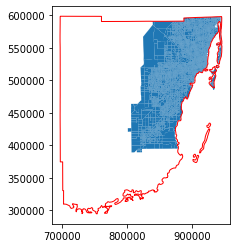

In [12]:
ax = md_maz_info.plot()
md_county.plot(ax=ax, color='none', edgecolor='red');

Because the unit of measure in EPSG:2236 is approximately a foot, the
`area` property of the `md_maz_info` GeoDataFrame gives the area in 
square feet.  To express population density in persons per square mile,
we need to multiply by 5280 (feet per mile) squared.

In [13]:
md_maz_info["Population Density"] = md_maz_info.POP / md_maz_info.area * 5280**2

A first attempt at drawing a population density choropleth shows
something is wrong; the entire county is displayed as nearly zero.

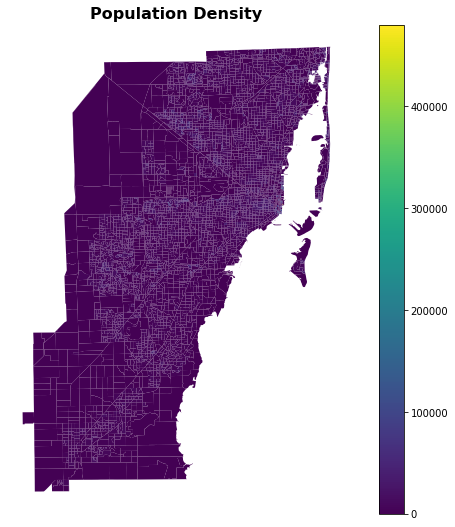

In [14]:
fig, ax = plt.subplots(figsize=(12,9))
ax.axis('off') # don't show axis
ax.set_title("Population Density", fontweight='bold', fontsize=16)
ax = md_maz_info.plot(ax=ax, column="Population Density", legend=True)

The problem is identifiable in the legend: the scale goes up
to nearly half a million people per square mile, which is 
an enormous value, and generally not achievable unless a zone
is basically just skyscrapers.  This does apply to a handful of 
MAZ's in downtown Miami, but the density everywhere else is 
so much lower that this map is meaningless.

We can create a more meaningful map by clipping the top of the
range to a more reasonable value, say only 40,000 people per
square mile.

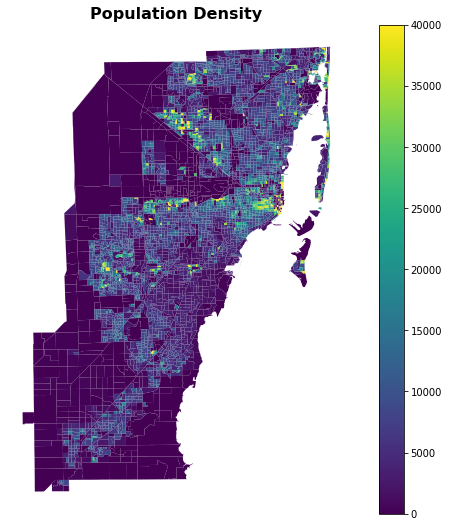

In [15]:
fig, ax = plt.subplots(figsize=(12,9))
ax.axis('off') # don't show axis
ax.set_title("Population Density", fontweight='bold', fontsize=16)
ax = md_maz_info.plot(ax=ax, column=np.clip(md_maz_info["Population Density"], 0, 40_000), legend=True)